In [2]:
import numpy as np
from matplotlib import pyplot as plt
# import pandas as pd
import os
import cv2
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten
import copy
import pickle

# Importing data

## Test data

In [3]:
def data_import(data_path):
    class_labels = os.listdir(data_path) # reads directory names as class-labels
    data=[]
    labels=[]
    for class_ in class_labels:
        if class_ == '.DS_Store':
            continue
        class_path = data_path+'/'+class_
        imgs = os.listdir(class_path) # reads images names to read
        for img in imgs:
            if img == '.DS_Store':
                continue
            data.append(cv2.imread(class_path+'/'+img, cv2.IMREAD_GRAYSCALE))
            labels.append(int(class_))

    return np.array(data), np.array(labels)

In [4]:
test_path='./Group_10/test'
train_path='./Group_10/train'
val_path='./Group_10/val'
# test_data, test_labels = data_import(test_path)
# train_data, train_labels = data_import(train_path)
# val_data, val_labels = data_import(val_path)

# with open('test_data', mode='wb') as f:
#     pickle.dump(test_data, f)
# with open('train_data', mode='wb') as f:
#     pickle.dump(train_data, f)
# with open('val_data', mode='wb') as f:
#     pickle.dump(val_data, f)

# with open('test_labels', mode='wb') as f:
#     pickle.dump(test_labels, f)
# with open('train_labels', mode='wb') as f:
#     pickle.dump(train_labels, f)
# with open('val_labels', mode='wb') as f:
#     pickle.dump(val_labels, f)

with open('test_data', mode='rb') as f:
    test_data = pickle.load(f)
with open('train_data', mode='rb') as f:
    train_data = pickle.load(f)
with open('val_data', mode='rb') as f:
    val_data = pickle.load(f)

with open('test_labels', mode='rb') as f:
    test_labels = pickle.load(f)
with open('train_labels', mode='rb') as f:
    train_labels = pickle.load(f)
with open('val_labels', mode='rb') as f:
    val_labels = pickle.load(f)

print('Summary of data')
print(f'No. of train images: {len(train_data)}')
print(f'No. of test images: {len(test_data)}')
print(f'No. of val images: {len(val_data)}')


Summary of data
No. of train images: 11385
No. of test images: 3795
No. of val images: 3795


# Model

In [5]:
initializer = keras.initializers.RandomUniform(minval=-1, maxval=1, seed=6)
init_config = initializer.get_config()

In [6]:
# Three layer FCNN
model_3 = keras.Sequential([
    Flatten(input_shape=(28,28), name='Input_layer'), # image data as input
    Dense(250, activation='sigmoid', kernel_initializer=initializer, bias_initializer=keras.initializers.Zeros(), name='Hidden_layer_1'),
    Dense(500, activation='sigmoid', kernel_initializer=initializer, bias_initializer=keras.initializers.Zeros(), name='Hidden_layer_2'),
    Dense(250, activation='sigmoid', kernel_initializer=initializer, bias_initializer=keras.initializers.Zeros(), name='Hidden_layer_3'),
    Dense(10, activation='softmax', kernel_initializer=initializer, bias_initializer=keras.initializers.Zeros(), name='Output')
], name='FCNN_3layer')

In [7]:
model_3.summary()

Model: "FCNN_3layer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_layer (Flatten)       (None, 784)               0         
                                                                 
 Hidden_layer_1 (Dense)      (None, 250)               196250    
                                                                 
 Hidden_layer_2 (Dense)      (None, 500)               125500    
                                                                 
 Hidden_layer_3 (Dense)      (None, 250)               125250    
                                                                 
 Output (Dense)              (None, 10)                2510      
                                                                 
Total params: 449,510
Trainable params: 449,510
Non-trainable params: 0
_________________________________________________________________


## SGD

In [8]:
earlystopping = keras.callbacks.EarlyStopping(monitor='loss', min_delta=1e-4, patience=3, verbose=1)
modelCheckpoints = keras.callbacks.ModelCheckpoint(filepath='./modelCheckpoints/SGD/model.{epoch:02d}-{loss:.2f}.h5', verbose=0)
sgd_optimizer = keras.optimizers.SGD(learning_rate=0.001,name='SGD', momentum=0)
model_3.compile(optimizer=sgd_optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [9]:
save_weights = []
for layer in model_3.layers:
    save_weights.append(layer.get_weights())

In [10]:
history = model_3.fit(x=train_data, y=train_labels, batch_size=1, epochs=100_000,
                    callbacks=[earlystopping, modelCheckpoints],
                    verbose=1,
                    validation_split=0.0, validation_data=(val_data, val_labels), validation_batch_size=None)

Epoch 1/100000


2023-03-15 23:16:16.297462: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


11385/11385 [==============================] - 8s 674us/step - loss: 0.9527 - accuracy: 0.7100 - val_loss: 0.4222 - val_accuracy: 0.8511
Epoch 2/100000
11385/11385 [==============================] - 8s 699us/step - loss: 0.3701 - accuracy: 0.8750 - val_loss: 0.3269 - val_accuracy: 0.8880
Epoch 3/100000
11385/11385 [==============================] - 8s 672us/step - loss: 0.2852 - accuracy: 0.9033 - val_loss: 0.2621 - val_accuracy: 0.9162
Epoch 4/100000
11385/11385 [==============================] - 8s 673us/step - loss: 0.2435 - accuracy: 0.9174 - val_loss: 0.2292 - val_accuracy: 0.9209
Epoch 5/100000
11385/11385 [==============================] - 8s 662us/step - loss: 0.2092 - accuracy: 0.9299 - val_loss: 0.2269 - val_accuracy: 0.9252
Epoch 6/100000
11385/11385 [==============================] - 8s 696us/step - loss: 0.1886 - accuracy: 0.9364 - val_loss: 0.2060 - val_accuracy: 0.9320
Epoch 7/100000
11385/11385 [==============================] - 8s 684us/step - loss: 0.1772 - accuracy: 

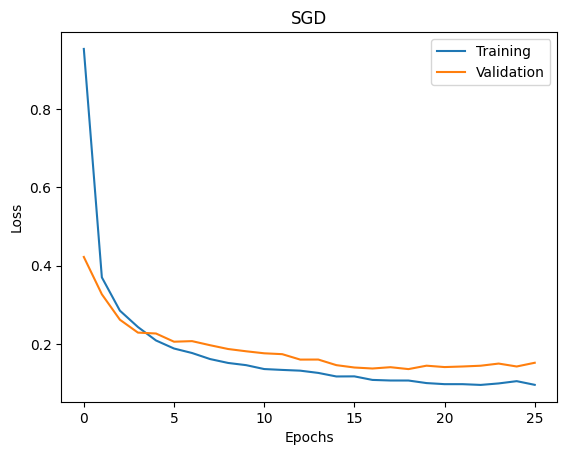

In [11]:
plt.figure()
plt.title("SGD")
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.legend()

In [12]:
model_3.evaluate(test_data, test_labels)

119/119 [==============================] - 0s 707us/step - loss: 0.1589 - accuracy: 0.9486


[0.1588890552520752, 0.948616623878479]

### Test

In [13]:
pred_labels = model_3.predict(test_data, verbose=0)
pred_labels = np.argmax(pred_labels, axis=1)

confusion_matrix = tf.math.confusion_matrix(test_labels, pred_labels, num_classes=10)
print('(SGD)Confusion matrix on test data:\n')
print(confusion_matrix.numpy())

(SGD)Confusion matrix on test data:

[[713   1  18   0   0   0  20   7   0   0]
 [  0 739   7   0   0   0   5   8   0   0]
 [ 10   8 708   0   0   0  18  15   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [ 12   3  22   0   0   0 719   3   0   0]
 [  6   7  21   0   0   0   4 721   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]]


## Batch GD

In [14]:
#reset model
for weight, layer in zip(save_weights, model_3.layers):
    layer.set_weights(weight)

In [15]:
modelCheckpointsBGD = keras.callbacks.ModelCheckpoint(filepath="./modelCheckpoints/BatchGradDescent/model.{epoch:02d}-{loss:.2f}.h5")
bgd_optimizer = keras.optimizers.SGD(learning_rate=0.001, name='Batch_Grad_Decent', momentum=0)
model_3.compile(optimizer=bgd_optimizer,
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

In [16]:
history = model_3.fit(x=train_data, y=train_labels, batch_size=11_385, epochs=100_000,
                    callbacks=[earlystopping, modelCheckpointsBGD],
                    verbose=1,
                    validation_split=0.0, validation_data=(val_data, val_labels), validation_batch_size=None)

Epoch 1/100000
1/1 [==============================] - 0s 451ms/step - loss: 10.4319 - accuracy: 0.1027 - val_loss: 10.2469 - val_accuracy: 0.1022
Epoch 2/100000
1/1 [==============================] - 0s 104ms/step - loss: 10.3547 - accuracy: 0.1027 - val_loss: 10.1739 - val_accuracy: 0.1022
Epoch 3/100000
1/1 [==============================] - 0s 102ms/step - loss: 10.2784 - accuracy: 0.1032 - val_loss: 10.1020 - val_accuracy: 0.1020
Epoch 4/100000
1/1 [==============================] - 0s 102ms/step - loss: 10.2031 - accuracy: 0.1040 - val_loss: 10.0310 - val_accuracy: 0.1028
Epoch 5/100000
1/1 [==============================] - 0s 99ms/step - loss: 10.1288 - accuracy: 0.1047 - val_loss: 9.9609 - val_accuracy: 0.1033
Epoch 6/100000
1/1 [==============================] - 0s 102ms/step - loss: 10.0556 - accuracy: 0.1053 - val_loss: 9.8916 - val_accuracy: 0.1036
Epoch 7/100000
1/1 [==============================] - 0s 100ms/step - loss: 9.9833 - accuracy: 0.1060 - val_loss: 9.8230 - val_

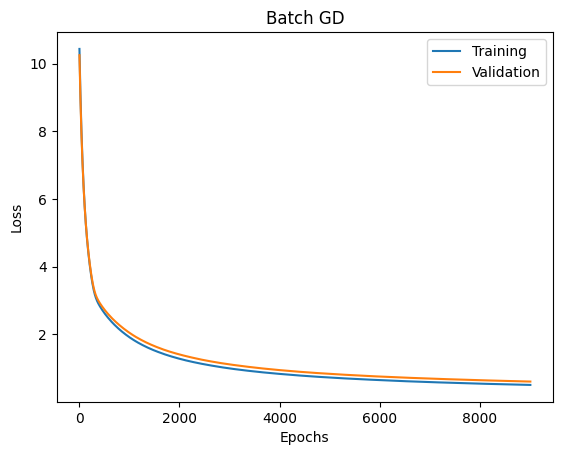

In [18]:
plt.figure()
plt.title("Batch GD")
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.legend()